GitHub URL
https://github.com/JSH99

1. Settings

1) important required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

In [2]:
!unzip "horse_donkey.zip"

Archive:  horse_donkey.zip
   creating: dev/
   creating: dev/donkey/
  inflating: dev/donkey/donkey-3433969_640.jpg  
  inflating: dev/donkey/donkey-3619022_640.jpg  
  inflating: dev/donkey/donkey-3636234_640.jpg  
  inflating: dev/donkey/donkey-3640698_640.jpg  
  inflating: dev/donkey/donkey-3728294_640.jpg  
  inflating: dev/donkey/donkey-3931367_640.jpg  
   creating: dev/horse/
  inflating: dev/horse/horse-2642142_640.jpg  
  inflating: dev/horse/horse-2732654_640.jpg  
  inflating: dev/horse/horse-2776815_640.jpg  
  inflating: dev/horse/horse-3114412_640.jpg  
  inflating: dev/horse/horse-3385539_640.jpg  
  inflating: dev/horse/horse-4071342_640.jpg  
  inflating: dev/horse/horse-5815611_640.jpg  
   creating: test/
   creating: test/donkey/
  inflating: test/donkey/donkey-4134955_640.jpg  
  inflating: test/donkey/donkey-4282436_640.jpg  
  inflating: test/donkey/donkey-4441245_640.jpg  
  inflating: test/donkey/donkey-4537117_640.jpg  
  inflating: test/donkey/donkey-468664

2) Hyperparameter

In [3]:
batch_size = 16
learning_rate = 0.0001
epoch = 20

n_node = 1024
dropratio = 0.5

imgsize = 256

2. Data Loader

In [4]:
# 1. Train data
img_dir = "train"

train_data = dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(imgsize*2),
            transforms.RandomCrop(imgsize),
            transforms.RandomHorizontalFlip(),
    
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(dataset=train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

35


In [5]:
# 2. Develop data
img_dir = "dev"

dev_data = dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))

dev_batch = data.DataLoader(dataset=dev_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)

# 3. Test data
img_dir = "test"

test_data = dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))

test_batch = data.DataLoader(dataset=test_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)

nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
         %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# of classes: 2
['donkey', 'horse']
{'donkey': 0, 'horse': 1}
35
Training: 35, Dev: 13, Test: 17


(None,)

In [6]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['donkey', 'horse']
['donkey', 'horse']
['donkey', 'horse']


3. Model

1) Pretrained VGG Model

In [7]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

2) Costomized Fully Model

In [8]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])
        
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass)
        )
        
        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
                
    def forward(self, x):
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

3) Model on GPU

In [9]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [10]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

4. Optimizer & Loss

In [11]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

5. Train

In [12]:
import utils

total_time = 0
disp_step = 10

to_train = True

if(to_train==False):
    netname = './nets/donkeyhorse_vgg19_10.pkl'
    model = torch.load(netname)
else:
    print("3 layer, n_node; %d, dropratio: %.2f"%(n_node, dropratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"
             %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = './nets/catdog_vgg19'
    
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        
        for img, label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
        
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        
        if(i % disp_step==0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl' %i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            model.eval()
            
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr =  utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, "
                     %(train_corr, dev_corr, test_corr)),
            model.train()
            print("time: %.2f sec.." %total_time)
            
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node; 1024, dropratio: 0.50
Correct of train: 48.57, dev: 46.15, test: 41.18
0..

[0/20] loss: 3.363, 
Correct of train: 51.43, dev: 53.85, test: 35.29, 
time: 0.97 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 1.498, 
Correct of train: 85.71, dev: 69.23, test: 76.47, 
time: 10.56 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.816, 
Correct of train: 94.29, dev: 84.62, test: 82.35, 
time: 19.12 sec..
Total time: 19.12 sec


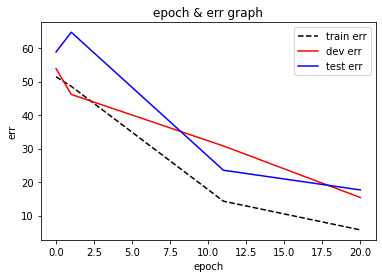

In [13]:
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show

6. Evaliation for dev & test data

Normalized confusion matrix


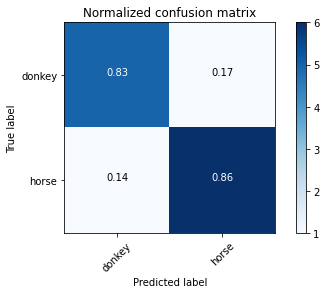

Confusion matrix, without normalization


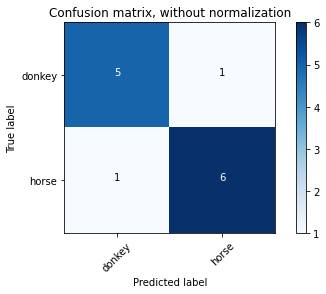

	 acc  |	 pre  |	 rec  |	 f1
 donkey: 0.85 |	 0.83 |	 0.83 |	 0.83
 horse: 0.85 |	 0.86 |	 0.86 |	 0.86
*accuracy: 0.85, precision: 0.85, recall: 0.85, *f1 score: 0.85
[AP]
donkey: 0.86
horse: 0.85

[mAP] 0.856
[miAP] 0.923


(array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]),
 array([0.84097248, 0.57678843, 0.63698059, 0.8693518 , 0.94667345,
        0.87892479, 0.68695289, 0.91530925, 0.65981025, 0.93261564,
        0.64691627, 0.62013841, 0.76298976]))

In [14]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


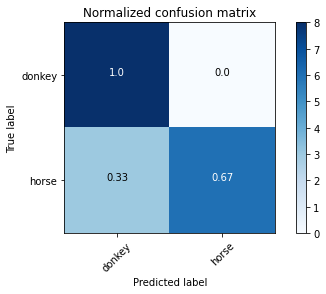

Confusion matrix, without normalization


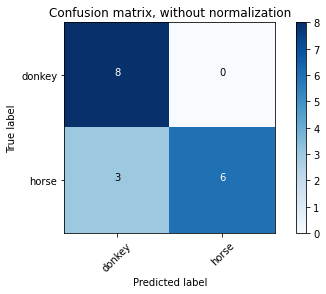

	 acc  |	 pre  |	 rec  |	 f1
 donkey: 0.82 |	 0.73 |	 1.00 |	 0.84
 horse: 0.82 |	 1.00 |	 0.67 |	 0.80
*accuracy: 0.82, precision: 0.86, recall: 0.83, *f1 score: 0.82
[AP]
donkey: 0.97
horse: 0.98

[mAP] 0.976
[miAP] 0.912


In [15]:
model.eval()
_, _, _ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: donkey
 True predicted images/total donkey category: 5 / 6
Predicted probability:
[0.5767884 0.4232116]


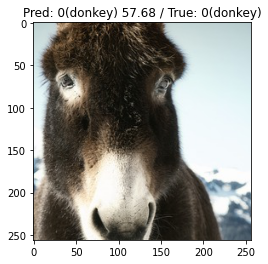

Predicted probability:
[0.6369806 0.3630194]


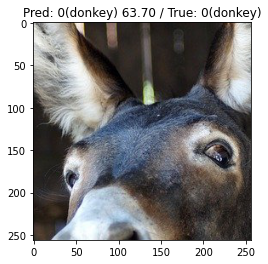

 False predicted images/total donkey category: 1 / 6
Predicted probability:
[0.15902753 0.8409725 ]


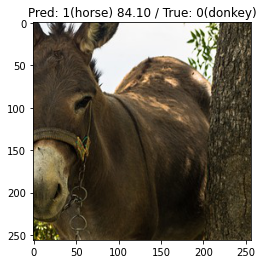

Category: horse
 True predicted images/total horse category: 6 / 7
Predicted probability:
[0.08469073 0.91530925]


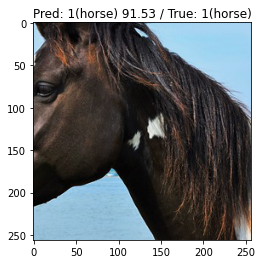

Predicted probability:
[0.34018973 0.65981025]


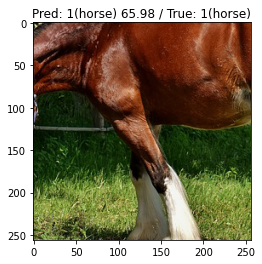

 False predicted images/total horse category: 1 / 7
Predicted probability:
[0.6869529  0.31304714]


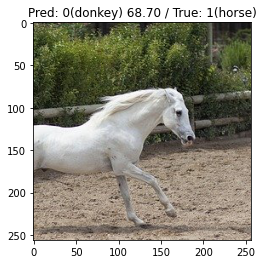

In [16]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)